In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import confusion_matrix

import dataset
import data_reader
import plots

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
EXP_NAME = "ejemplo_2"

DATA_SET_NAME = f"data_set_x20_100%_split"

In [4]:
def wsi_class(wsi_data_set):
    global net
    """
    Input: 
    - wsi_data_set, patches from a given WSI, dataset object
    - y, patch labels
    Outputs:
    - output, Prediction
    """
    wsi_dataloader = DataLoader(wsi_data_set, batch_size=64)
    outputs = []
    loss = 0

    for batch_X, batch_y in iter(wsi_dataloader):
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device) 

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        normalize = transforms.Normalize(mean=mean, std=std)

        for i, x in enumerate(batch_X):
            batch_X[i] = normalize(batch_X[i]/255) # Np array
        
        output = net(batch_X)
        outputs.extend(output.cpu())
        #print(batch_y.size(), output.size())
        loss += nn.BCELoss()(output, batch_y).cpu()

    y_pred = [torch.argmin(i) for i in outputs] # 1 means positive diagnosis: (1,0) => 1

    output = sum(y_pred)/len(y_pred)
    loss = loss/len(wsi_data_set)

    return output, loss

Read lmdb


  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\torch\utils\data\_utils\collate.py:146: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


Mean Loss:  0.015108648
Acc:  0.84
PRC:  0.875
REC:  0.9545454545454546
f1:  0.9130434782608695
CONF: 
 [[ 0  3]
 [ 1 21]] 



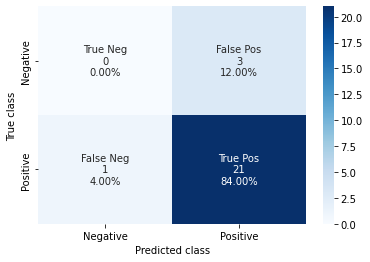

In [5]:
SPLIT_NAME = DATA_SET_NAME + f"{1}"
MODEL_NAME = EXP_NAME + f"{0}"

net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

X, y, _ , case_ids = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/WSI/patches/{SPLIT_NAME}")

case_ids = [case_id[2:38] for case_id in case_ids] # Taking only the case_id, not patch id

outputs, loss, labels = [], [], []
unique_case_ids = np.unique(case_ids)
case_ids = np.array(case_ids)

for unique_case_id in tqdm(unique_case_ids):

    net.eval()
    with torch.no_grad():
        ii = np.where(case_ids == unique_case_id)[0]

        wsi_data_set = dataset.PatchDataset([], [], [])

        wsi_data_set.inputs.extend(X[ii[0]:ii[-1]])# Taking the patches from a given wsi
        wsi_data_set.labels.extend(y[ii[0]:ii[-1]])
        wsi_data_set.case_ids.extend(case_ids)
        
        output = wsi_class(wsi_data_set)
        outputs.append(output[0])
        loss.append(output[1])
        labels.append(y[ii[0]][0]) # OHE to binary

        del wsi_data_set

loss = np.mean(loss)

out = [1 if output>0.5 else 0 for output in outputs]

conf_m = confusion_matrix(labels, out, labels=[0, 1])

acc = (conf_m[0][0]+conf_m[1][1])/(conf_m[1][0]+conf_m[0][1]+conf_m[1][1]+conf_m[0][0])
prc = conf_m[1][1]/(conf_m[1][1]+conf_m[0][1])
rec = conf_m[1][1]/(conf_m[1][1]+conf_m[1][0])
f1 = 2*prc*rec/(prc+rec)

print("Mean Loss: ", loss)
print("Acc: ", acc)
print("PRC: ", prc) # TP/TP+FP
print("REC: ", rec) # TP/TP+FN
print("f1: ", f1)
print("CONF: \n", conf_m, "\n")

plots.plot_conf(SPLIT_NAME, conf_m)


In [7]:
print(unique_case_ids)
print(labels)

# fd232b29-8298-420c-bd99-c61fc27cc1ad does not meet protocol
# 1be7d418-81ce-52c4-8feb-7fe23401bf24 does not meet protocol

['0678bef8-d0a3-42ad-810b-377f692b4575'
 '0972f52a-f558-40ed-9f8d-682da29461f2'
 '2545c7a6-9557-48c8-b7a7-2ec068390f70'
 '3c1f1433-58c1-4ff2-9b0b-e7811cc67678'
 '43e53137-057f-4f0d-a01e-210ee35c6e1a'
 '449085a5-6126-4640-8f4c-a80e9ef56996'
 '4565b134-c896-44c1-a24f-cb133d290331'
 '587350db-5cfc-406b-928c-aaa9387a0202'
 '6668d531-59a4-4f2a-a18e-c3f5a19c255d'
 '66699aa9-428d-4f42-a939-f2b5e55033ec'
 '7b6b91e0-8229-4c12-abb3-92d8242fa547'
 '7c73d3ea-d732-42cf-b9fa-92739e648cdb'
 '7caee464-f84c-45ac-ad9e-d3f234d51678'
 '8e748bd9-f5bf-4be9-ae06-97a2b279bf8c'
 '9600988b-837f-461e-8dc5-136085e20dd0'
 '9ea40004-75b6-4317-bc57-f873baa7f10e'
 'b35e7197-5624-462f-a69b-c7b98b68c9af'
 'b681f69a-e664-4e9d-a479-e9e8e08f0c6d'
 'bbde7752-3c5e-4730-abf0-f4b6b0b23077'
 'c630b17c-e321-4b90-8b8d-a3ca92cba43a'
 'cef8f965-3ffe-4aa6-a79c-dd03b7885fa9'
 'd95dd0b2-c8a1-41cd-8d06-31fcd7ff92bc'
 'efa22162-d986-4d92-bb50-516f5450caf8'
 'fb9c07db-d18d-414c-9abc-14b6c7fd7bc3'
 'feba0925-0edd-4077-a5e1-7c93d33283ae']

In [10]:
roc = []

# ROC
for i in reversed(np.linspace(0,1,10000)):
    out = [1 if output>i else 0 for output in outputs]
    conf_m = confusion_matrix(labels, out, labels=[0, 1])
    roc.append(conf_m[1][1]/(conf_m[1][0]+conf_m[1][1]))

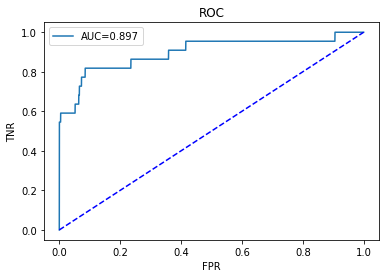

In [11]:
plots.plot_roc(SPLIT_NAME, roc)

In [ ]:
# Choosing only the images from the according splits (10CV)

SPLITS = 1 # Number of iterations > n_splits

for SPLIT in range(SPLITS):
    MODEL_NAME = EXP_NAME + f"{SPLIT}"
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    test_set = dataset.PatchDataset([], [], [])

    X_, y_, _ , case_ids_ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/WSI/patches/{SPLIT_NAME}")

    test_set.inputs.extend(X_)
    test_set.labels.extend(y_)
    test_set.case_ids.extend(case_ids_)

    print(f"Loading model {MODEL_NAME}\n")

    net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

    test_wsi()

    del test_set
